# Autoencoders on CIFAR-10

## Task Description

We have seen how to build an Autoencoder for the grayscale images of the Fashion-MNIST dataset. In this Exercise, you will build one for the CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). This dataset contains **color** images with a 32x32 resolution.

### Preparation


In [1]:
import matplotlib.pyplot as plt


def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()



In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K



## 0. Parameters <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 32
CHANNELS = 3
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5

## 1. Prepare the data <a name="prepare"></a>

In [4]:
# Load the data
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

In [5]:
# Preprocess the data

def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = imgs.reshape(len(imgs),imgs.shape[1],imgs.shape[2],3)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

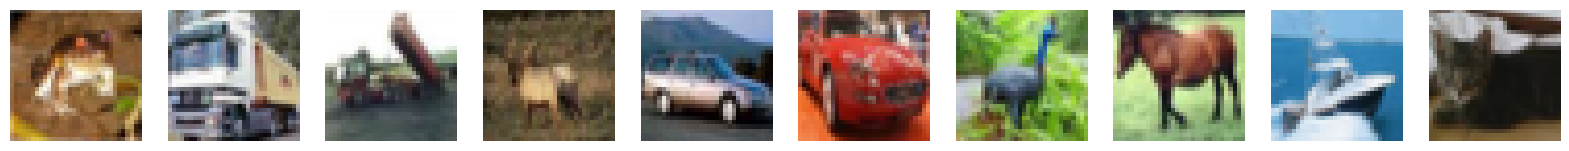

In [6]:
# Show some items of clothing from the training set
display(x_train)

## 2. Build the autoencoder <a name="build"></a>

In [7]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,346 (380.26 KB)

 Trainable params: 97,346 (380.26 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    CHANNELS,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,851 (964.26 KB)

 Trainable params: 246,851 (964.26 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Autoencoder
autoencoder = models.Model(
    encoder_input, decoder(encoder_output)
)  # decoder(encoder_output)
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 32, 32, 3)      │       246,851 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 344,197 (1.31 MB)

 Trainable params: 344,197 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Train the autoencoder <a name="train"></a>

In [10]:
# Compile the autoencoder
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [11]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint.keras",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [12]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.6515 - val_loss: 0.6360
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.6349 - val_loss: 0.6356
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.6343 - val_loss: 0.6353
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.6346 - val_loss: 0.6353
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.6345 - val_loss: 0.6350


In [13]:
# Save the final models
from pathlib import Path
Path("./models").mkdir(parents=True, exist_ok=True)
autoencoder.save("./models/autoencoder.keras")
encoder.save("./models/encoder.keras")
decoder.save("./models/decoder.keras")

## 4. Reconstruct using the autoencoder <a name="reconstruct"></a>

In [14]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Example real images


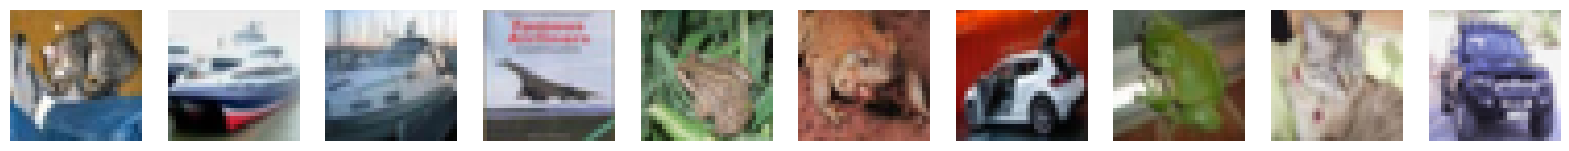

Reconstructions


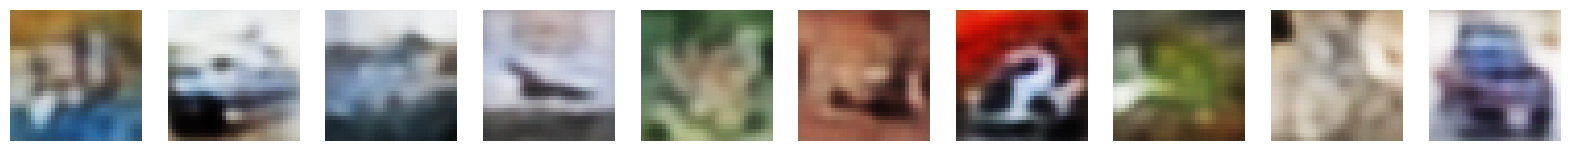

In [35]:
predictions = autoencoder.predict(example_images)

print("Example real images")
display(example_images)
print("Reconstructions")
display(predictions)

## 5. Embed using the encoder <a name="encode"></a>

In [34]:
# Encode the example images
embeddings = encoder.predict(example_images)

AttributeError: 'Encoder' object has no attribute 'predict'

In [17]:
# Some examples of the embeddings
print(embeddings[:10])

[[ 0.13520974  0.03653507]
 [-0.6595588  -2.5632782 ]
 [-0.6890363  -1.6350539 ]
 [-0.10907596 -1.7194988 ]
 [ 0.7246163   0.5354151 ]
 [-0.2447972   0.20692694]
 [-0.06258518  0.82827806]
 [-0.10114368  0.4893146 ]
 [ 1.293672   -0.86423606]
 [-0.2629976  -1.8191245 ]]


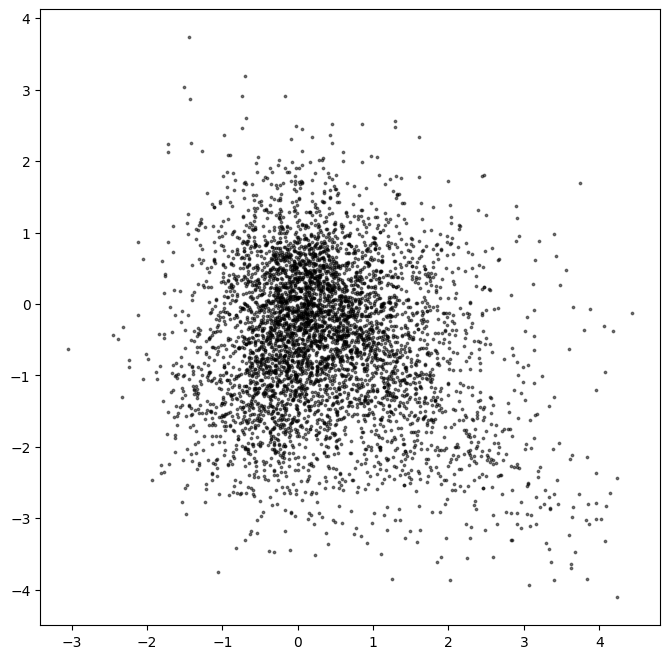

In [18]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

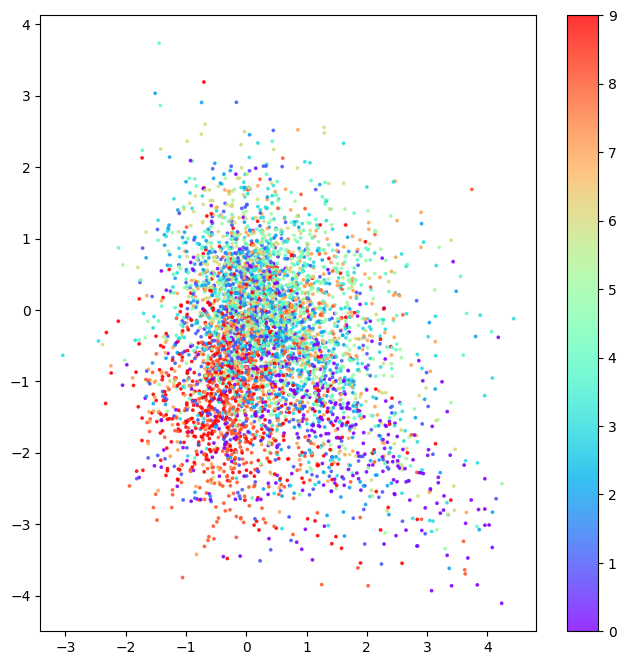

In [19]:
# Colour the embeddings by their label
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

In [36]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import numpy as np

class LayerConfig:
    def __init__(self, layer_type='Conv2D', **kwargs):
        self.layer_type = layer_type
        self.kwargs = kwargs

    def create_layer(self):
        if self.layer_type == 'Conv2D':
            return layers.Conv2D(
                filters=self.kwargs.get('filters', 32),
                kernel_size=self.kwargs.get('kernel_size', (3, 3)),
                strides=self.kwargs.get('strides', 2),
                activation=self.kwargs.get('activation', 'relu'),
                padding=self.kwargs.get('padding', 'same')
            )
        elif self.layer_type == 'Dense':
            return layers.Dense(**self.kwargs)
        elif self.layer_type == 'MaxPooling2D':
            return layers.MaxPooling2D(
                pool_size=self.kwargs.get('pool_size', (2, 2)),
                strides=self.kwargs.get('strides', None),
                padding=self.kwargs.get('padding', 'valid')
            )
        elif self.layer_type == 'Flatten':
            return layers.Flatten(**self.kwargs)
        elif self.layer_type == 'Conv2DTranspose':
            return layers.Conv2DTranspose(**self.kwargs)
        # Add more layer types as needed
        else:
            raise ValueError(f"Unsupported layer type: {self.layer_type}")

    def to_transpose(self):
        if self.layer_type == 'Conv2D':
            return LayerConfig(
                layer_type='Conv2DTranspose',
                filters=self.kwargs.get('filters', 32),
                kernel_size=self.kwargs.get('kernel_size', (3, 3)),
                strides=self.kwargs.get('strides', 2),
                activation=self.kwargs.get('activation', 'relu'),
                padding=self.kwargs.get('padding', 'same')
            )
        elif self.layer_type == 'MaxPooling2D':
            return LayerConfig(
                layer_type='UpSampling2D',
                size=self.kwargs.get('pool_size', (2, 2))
            )
        else:
            raise ValueError(f"Unsupported layer type for transposition: {self.layer_type}")

class Encoder:
    def __init__(self, input_shape, embedding_dim, layer_configs):
        self.input_shape = input_shape
        self.embedding_dim = embedding_dim
        self.layer_configs = layer_configs
        self.model = self.build_model()

    def build_model(self):
        encoder_input = layers.Input(shape=self.input_shape, name="encoder_input")
        self.encoder_input = encoder_input
        x = encoder_input

        for config in self.layer_configs:
            layer = config.create_layer()
            x = layer(x)

        self.shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!
        x = layers.Flatten()(x)
        encoder_output = layers.Dense(self.embedding_dim, name="encoder_output")(x)
        self.encoder_output = encoder_output

        encoder = models.Model(encoder_input, encoder_output)
        self.encoder = encoder
        #encoder.summary()
        return encoder
    
    def predict(self, input):
        return self.encoder.predict(input)

class Decoder:
    def __init__(self, embedding_dim, shape_before_flattening, layer_configs):
        self.embedding_dim = embedding_dim
        self.shape_before_flattening = shape_before_flattening
        self.layer_configs = layer_configs
        self.model = self.build_model()

    def build_model(self):
        decoder_input = layers.Input(shape=(self.embedding_dim,), name="decoder_input")
        self.decoder_input = decoder_input
        x = layers.Dense(np.prod(self.shape_before_flattening))(decoder_input)
        x = layers.Reshape(self.shape_before_flattening)(x)

        for config in reversed(self.layer_configs):
            transpose_config = config.to_transpose()
            layer = transpose_config.create_layer()
            x = layer(x)

        decoder_output = layers.Conv2D(
            CHANNELS,
            (3, 3),
            strides=1,
            activation="sigmoid",
            padding="same",
            name="decoder_output",
        )(x)

        decoder = models.Model(decoder_input, decoder_output)
        #decoder.summary()
        return decoder

# Example usage
IMAGE_SIZE = 32
CHANNELS = 3
EMBEDDING_DIM = 128

layer_configs = [
    LayerConfig(layer_type='Conv2D', filters=32, kernel_size=(3, 3), strides=2, activation='relu', padding='same'),
    LayerConfig(layer_type='Conv2D', filters=64, kernel_size=(3, 3), strides=2, activation='relu', padding='same'),
    LayerConfig(layer_type='Conv2D', filters=128, kernel_size=(3, 3), strides=2, activation='relu', padding='same')
]

encoder = Encoder(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), embedding_dim=EMBEDDING_DIM, layer_configs=layer_configs)
decoder = Decoder(embedding_dim=EMBEDDING_DIM, shape_before_flattening=encoder.shape_before_flattening, layer_configs=layer_configs)

In [37]:
class Autoencoder:
    def __init__(self, input_shape, embedding_dim, layer_configs):
        self.input_shape = input_shape
        self.embedding_dim = embedding_dim
        self.layer_configs = layer_configs
        self.encoder = Encoder(input_shape, embedding_dim, layer_configs)
        self.decoder = Decoder(embedding_dim, self.encoder.shape_before_flattening, layer_configs)
        self.autoencoder = self.build_autoencoder()

    def build_autoencoder(self):
        autoencoder_input = self.encoder.model.input
        autoencoder_output = self.decoder.model(self.encoder.model.output)
        autoencoder = models.Model(autoencoder_input, autoencoder_output)
        autoencoder.summary()
        return autoencoder

    def compile(self, optimizer='adam', loss='mse'):
        self.autoencoder.compile(optimizer=optimizer, loss=loss)

    def predict(self, x):
        return self.autoencoder.predict(x)

    def train(self, x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=None):
        model_checkpoint_callback = callbacks.ModelCheckpoint(
            filepath="./checkpoint.keras",
            save_weights_only=False,
            save_freq="epoch",
            monitor="loss",
            mode="min",
            save_best_only=True,
            verbose=0,
        )
        tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")
        self.autoencoder.fit(
            x_train, y_train, 
            batch_size=batch_size, 
            epochs=epochs, 
            validation_data=validation_data,
            callbacks=[model_checkpoint_callback, tensorboard_callback]
        )

autoencoder = Autoencoder(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), embedding_dim=EMBEDDING_DIM, layer_configs=layer_configs)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_11 (Functional)      │ (None, 32, 32, 3)      │       504,899 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 860,419 (3.28 MB)

 Trainable params: 860,419 (3.28 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
autoencoder.train(x_train, x_train, validation_data=(x_test, x_test))

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.6198 - val_loss: 0.5738
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.5709 - val_loss: 0.5681
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.5670 - val_loss: 0.5642
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.5630 - val_loss: 0.5628
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.5613 - val_loss: 0.5621


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Example real images


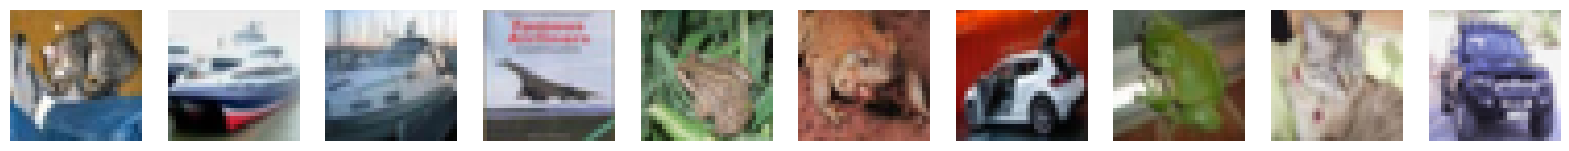

Reconstructions


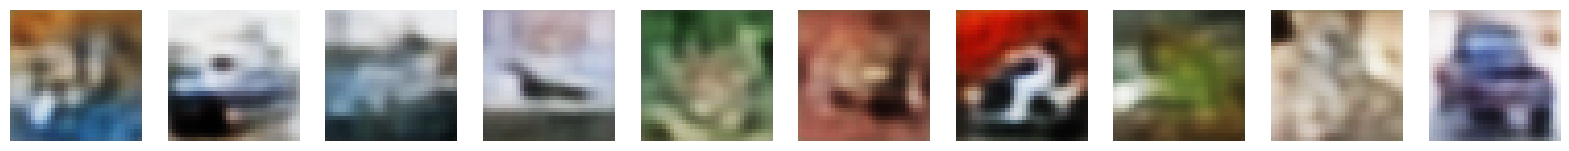

In [39]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]
predictions = autoencoder.predict(example_images)

print("Example real images")
display(example_images)
print("Reconstructions")
display(predictions)

In [40]:
def predict_and_visualize(autoencoder):

    n_to_predict = 5000
    example_images = x_test[:n_to_predict]
    example_labels = y_test[:n_to_predict]
    predictions = autoencoder.predict(example_images)

    print("Example real images")
    display(example_images)
    print("Reconstructions")
    display(predictions)

    # Encode the example images
    embeddings = autoencoder.encoder.predict(example_images)

    # Show the encoded points in 2D space
    figsize = 8

    plt.figure(figsize=(figsize, figsize))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
    plt.show()

    # Colour the embeddings by their label
    example_labels = y_test[:n_to_predict]
    print(embeddings.shape)

    figsize = 8
    plt.figure(figsize=(figsize, figsize))
    plt.scatter(
        embeddings[:, 0],
        embeddings[:, 1],
        cmap="rainbow",
        c=example_labels,
        alpha=0.8,
        s=3,
    )
    plt.colorbar()
    plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Example real images


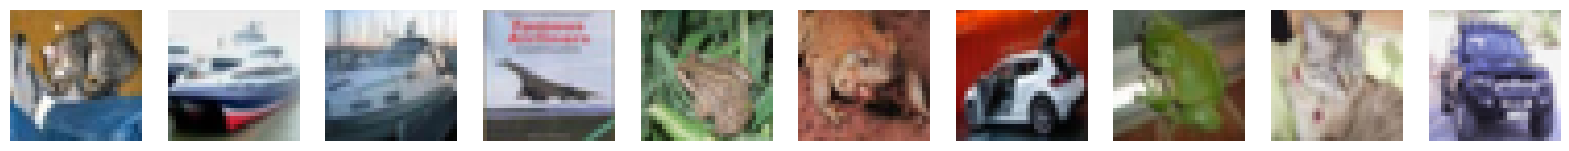

Reconstructions


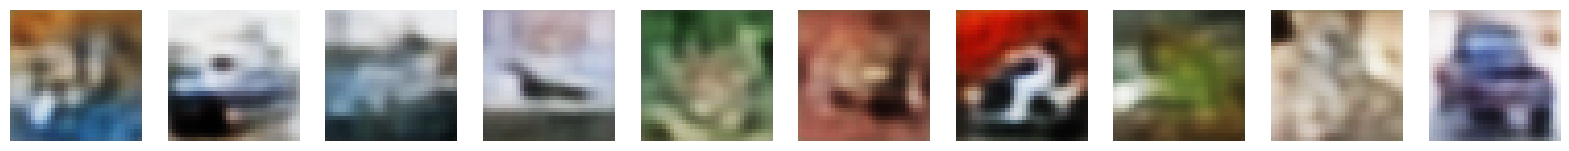

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step


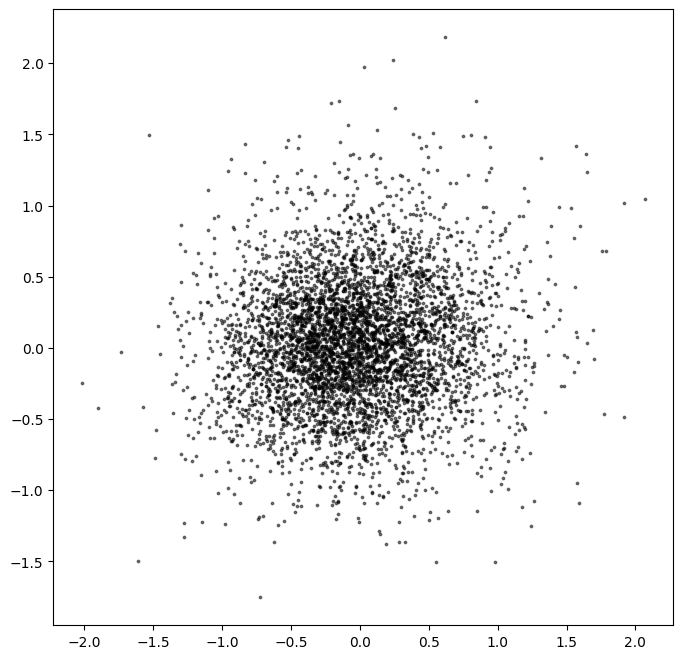

(5000, 128)


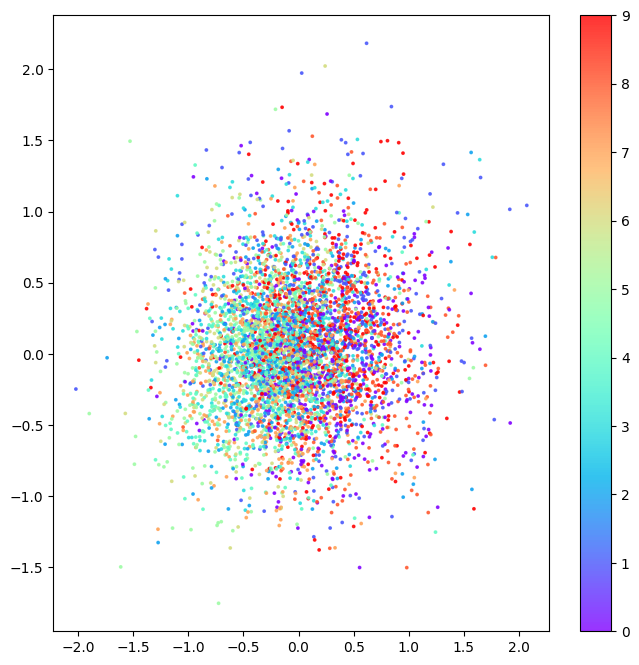

In [42]:
predict_and_visualize(autoencoder)

Reversed layers

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_14 (Functional)      │ (None, 32, 32, 3)      │       171,107 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,611 (1.27 MB)

 Trainable params: 332,611 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - loss: 0.6234 - val_loss: 0.5813
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - loss: 0.5774 - val_loss: 0.5730
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - loss: 0.5714 - val_loss: 0.5696
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - loss: 0.5687 - val_loss: 0.5683
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - loss: 0.5658 - val_loss: 0.5659
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Example real images


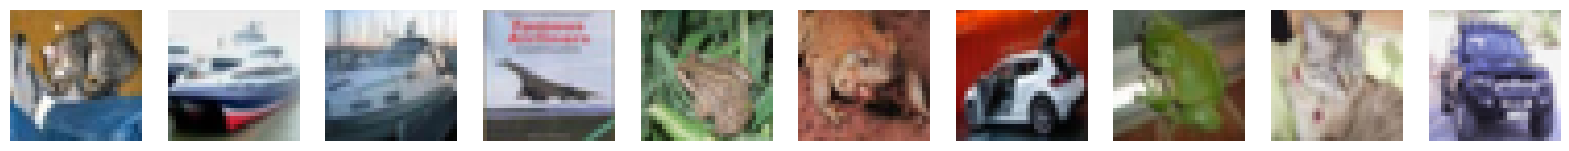

Reconstructions


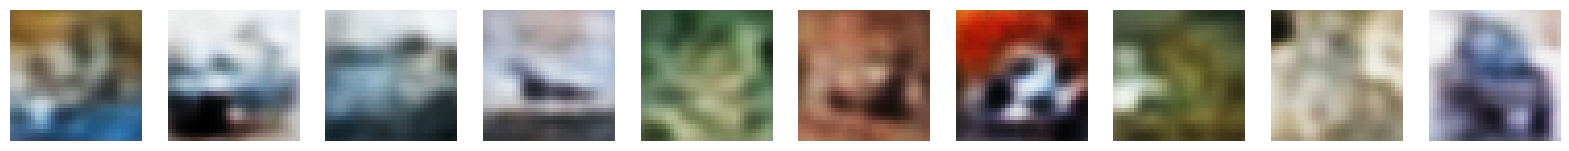

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


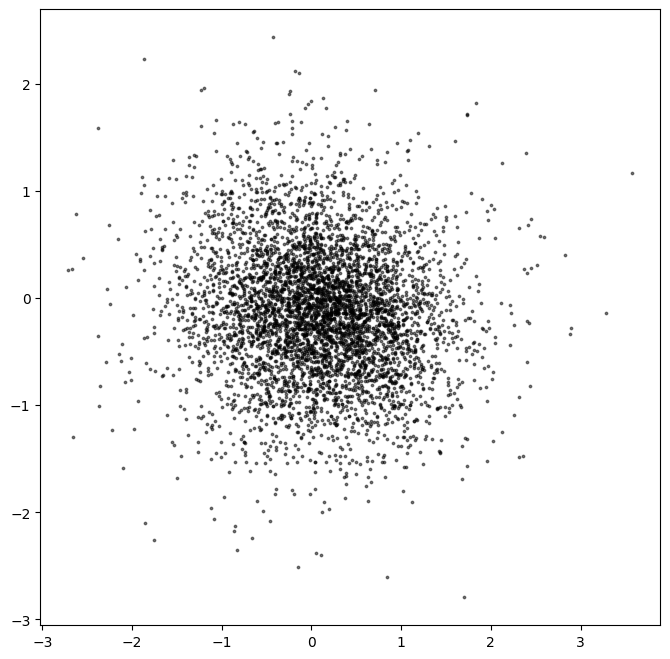

(5000, 128)


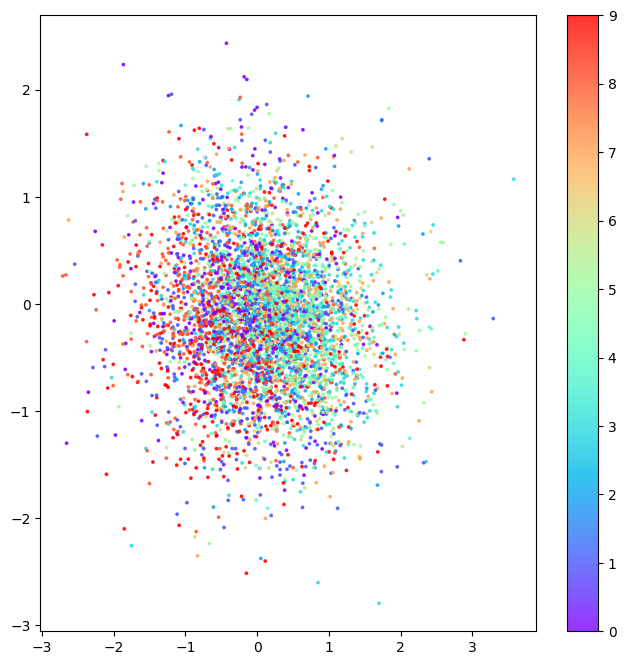

In [43]:
layer_configsReversed = [
    LayerConfig(layer_type='Conv2D', filters=128, kernel_size=(3, 3), strides=2, activation='relu', padding='same'),
    LayerConfig(layer_type='Conv2D', filters=64, kernel_size=(3, 3), strides=2, activation='relu', padding='same'),
    LayerConfig(layer_type='Conv2D', filters=32, kernel_size=(3, 3), strides=2, activation='relu', padding='same')
]

autoencoderReversed = Autoencoder(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), embedding_dim=EMBEDDING_DIM, layer_configs=layer_configsReversed)
autoencoderReversed.compile(optimizer='adam', loss='binary_crossentropy')
autoencoderReversed.train(x_train, x_train, validation_data=(x_test, x_test))
predict_and_visualize(autoencoderReversed)

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 16, 4)      │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 8, 8, 8)        │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 4, 4, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_20 (Functional)      │ (None, 32, 32, 3)      │        36,907 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,379 (278.82 KB)

 Trainable params: 71,379 (278.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.6395 - val_loss: 0.5909
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5874 - val_loss: 0.5842
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5826 - val_loss: 0.5817
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5804 - val_loss: 0.5800
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5787 - val_loss: 0.5787
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Example real images


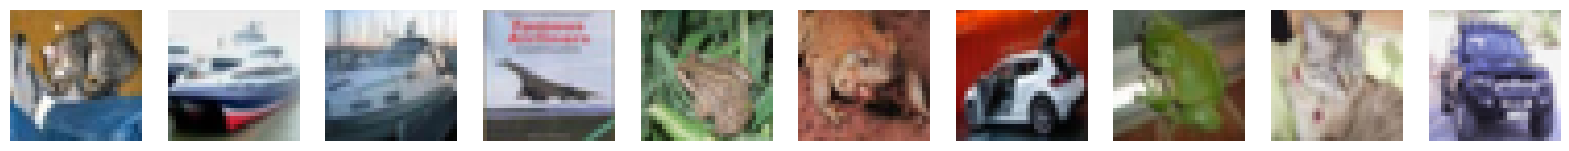

Reconstructions


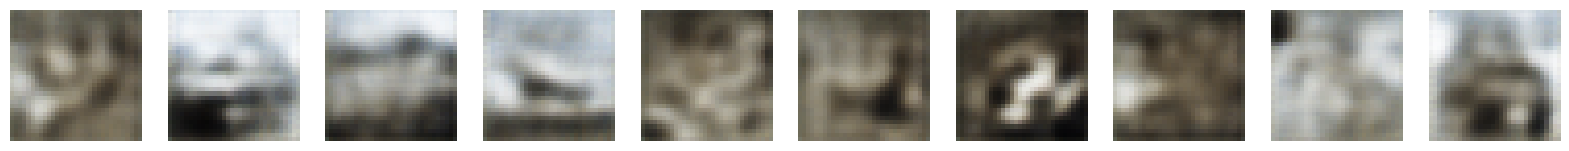

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step


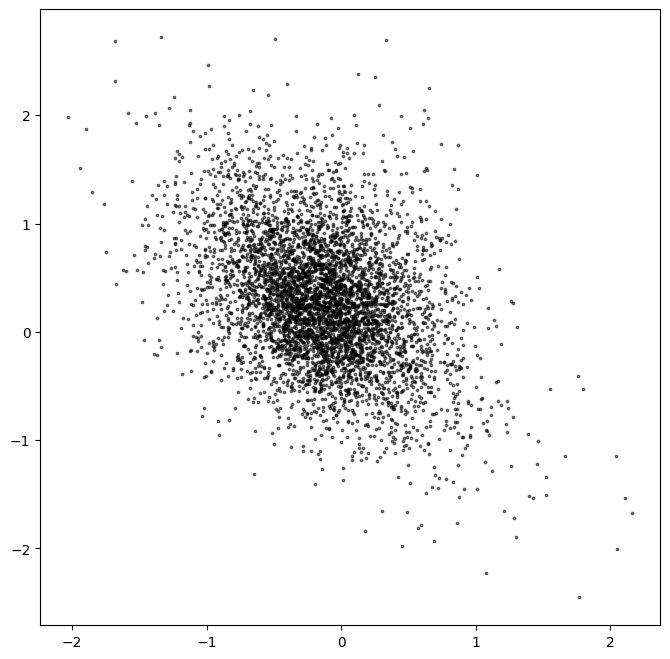

(5000, 128)


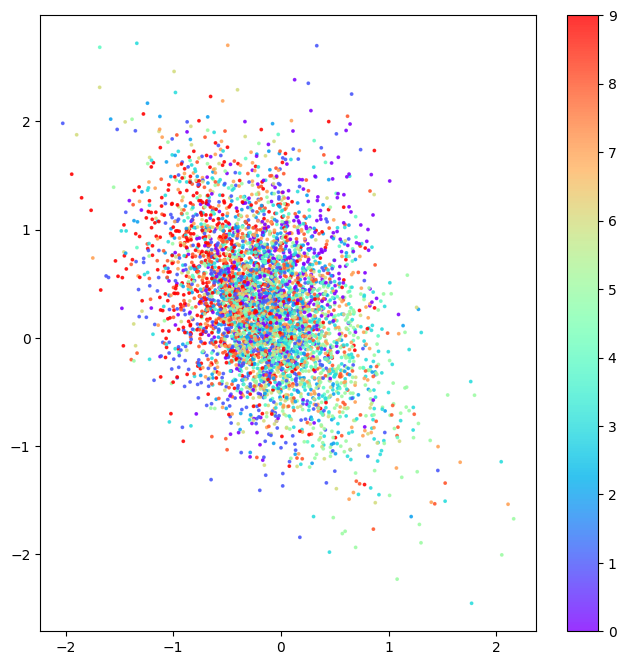

In [45]:
layer_configsSmall = [
    LayerConfig(layer_type='Conv2D', filters=4, kernel_size=(3, 3), strides=2, activation='relu', padding='same'),
    LayerConfig(layer_type='Conv2D', filters=8, kernel_size=(3, 3), strides=2, activation='relu', padding='same'),
    LayerConfig(layer_type='Conv2D', filters=16, kernel_size=(3, 3), strides=2, activation='relu', padding='same')
]

autoencoderSmall = Autoencoder(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), embedding_dim=EMBEDDING_DIM, layer_configs=layer_configsSmall)
autoencoderSmall.compile(optimizer='adam', loss='binary_crossentropy')
autoencoderSmall.train(x_train, x_train, validation_data=(x_test, x_test))
predict_and_visualize(autoencoderSmall)

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 16, 16, 16)     │         1,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 8, 8, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 4, 4, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_23 (Functional)      │ (None, 32, 32, 3)      │       372,259 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 597,459 (2.28 MB)

 Trainable params: 597,459 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.6251 - val_loss: 0.5801
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.5773 - val_loss: 0.5729
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.5711 - val_loss: 0.5691
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.5677 - val_loss: 0.5669
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.5656 - val_loss: 0.5664
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Example real images


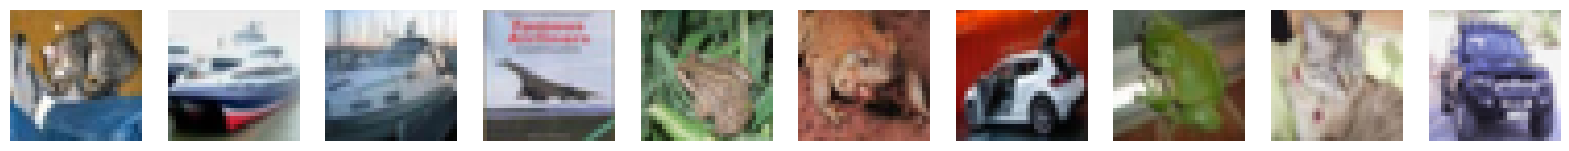

Reconstructions


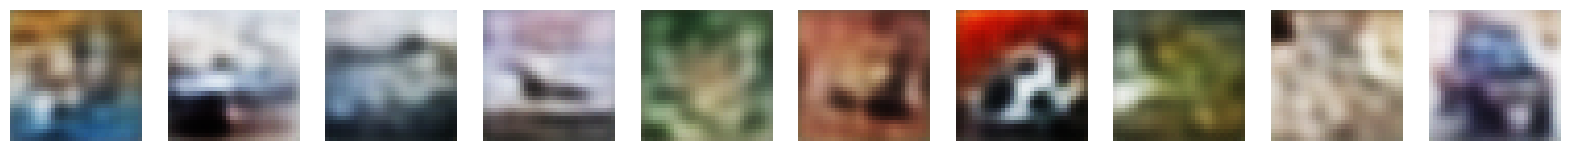

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


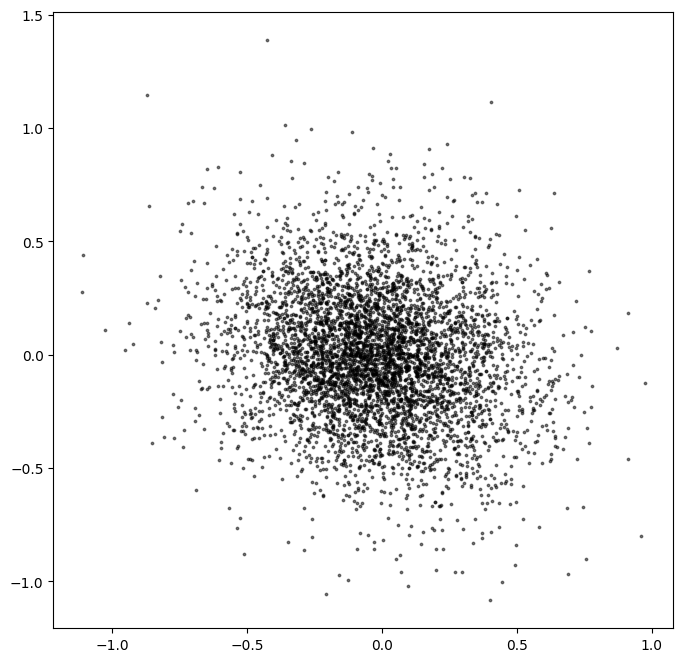

(5000, 128)


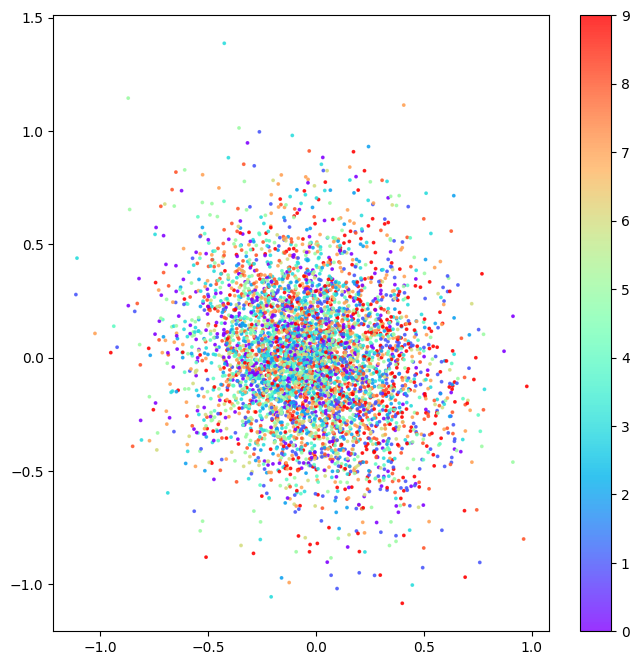

In [46]:
layer_configsLargeKernel = [
    LayerConfig(layer_type='Conv2D', filters=16, kernel_size=(6, 6), strides=2, activation='relu', padding='same'),
    LayerConfig(layer_type='Conv2D', filters=32, kernel_size=(6, 6), strides=2, activation='relu', padding='same'),
    LayerConfig(layer_type='Conv2D', filters=64, kernel_size=(6, 6), strides=2, activation='relu', padding='same')
]

autoencoderLargeKernel = Autoencoder(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), embedding_dim=EMBEDDING_DIM, layer_configs=layer_configsLargeKernel)
autoencoderLargeKernel.compile(optimizer='adam', loss='binary_crossentropy')
autoencoderLargeKernel.train(x_train, x_train, validation_data=(x_test, x_test))
predict_and_visualize(autoencoderLargeKernel)

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 16, 16, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 1, 1, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_32 (Functional)      │ (None, 32, 32, 3)      │     1,015,459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,440,963 (5.50 MB)

 Trainable params: 1,440,963 (5.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.6434 - val_loss: 0.5998
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.5940 - val_loss: 0.5846
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.5825 - val_loss: 0.5808
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.5784 - val_loss: 0.5769
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.5757 - val_loss: 0.5748
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Example real images


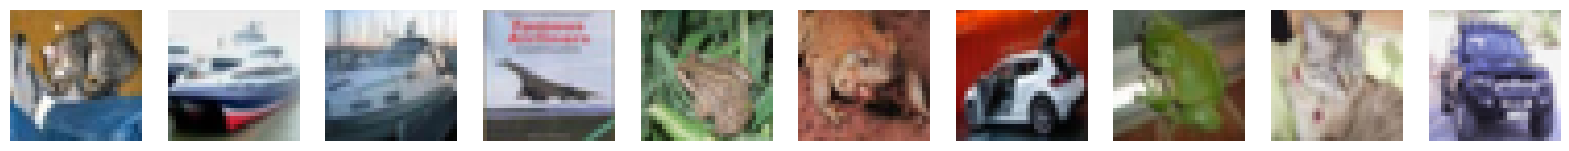

Reconstructions


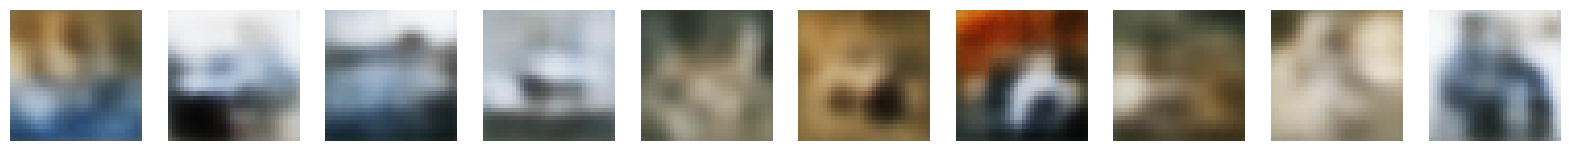

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


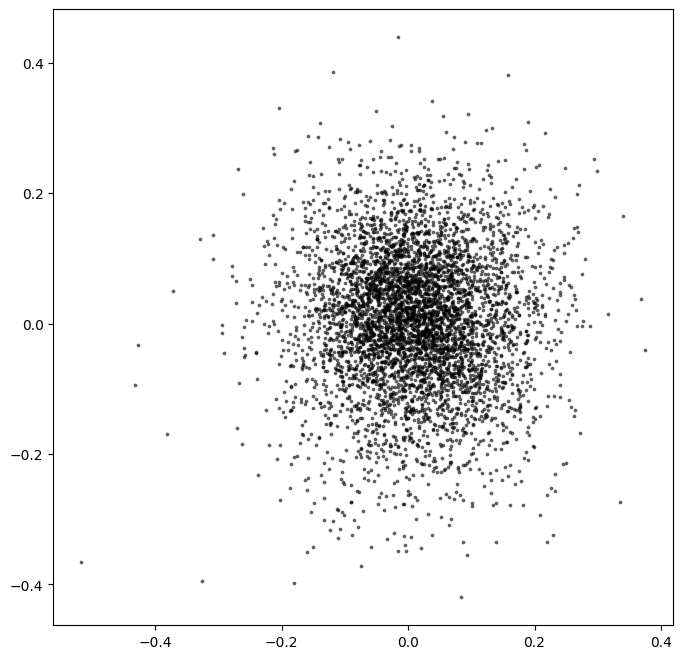

(5000, 128)


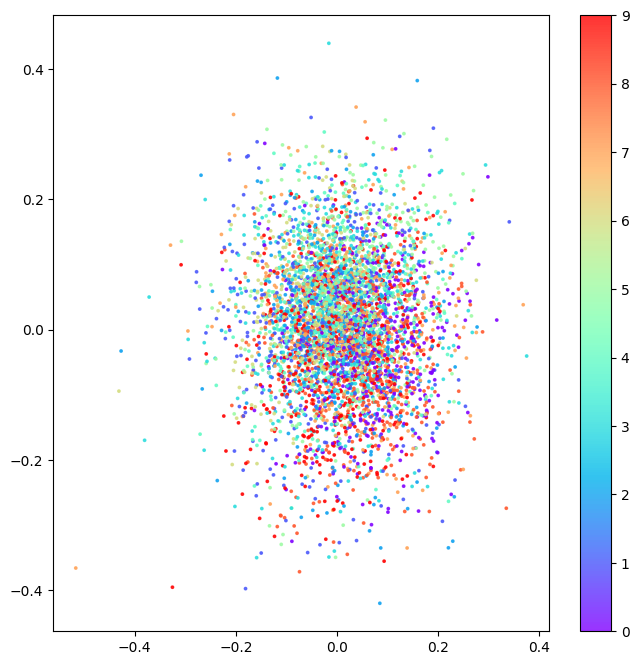

In [49]:
layer_configsManyLayers = [
    LayerConfig(layer_type='Conv2D', filters=16, kernel_size=(3, 3), strides=2, activation='relu', padding='same'),
    LayerConfig(layer_type='Conv2D', filters=32, kernel_size=(3, 3), strides=2, activation='relu', padding='same'),
    LayerConfig(layer_type='Conv2D', filters=64, kernel_size=(3, 3), strides=2, activation='relu', padding='same'),
    LayerConfig(layer_type='Conv2D', filters=128, kernel_size=(3, 3), strides=2, activation='relu', padding='same'),
    LayerConfig(layer_type='Conv2D', filters=256, kernel_size=(3, 3), strides=2, activation='relu', padding='same'),
]

autoencoderManyLayers = Autoencoder(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), embedding_dim=EMBEDDING_DIM, layer_configs=layer_configsManyLayers)
autoencoderManyLayers.compile(optimizer='adam', loss='binary_crossentropy')
autoencoderManyLayers.train(x_train, x_train, validation_data=(x_test, x_test))
predict_and_visualize(autoencoderManyLayers)

Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 16, 16, 64)     │       196,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 8, 8, 64)       │     1,048,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 4, 4, 64)       │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 2, 2, 64)       │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 1, 1, 64)       │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_35 (Functional)      │ (None, 32, 32, 3)      │     5,597,251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,195,139 (27.45 MB)

 Trainable params: 7,195,139 (27.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.5835 - val_loss: 0.5743
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.5726 - val_loss: 0.5730
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.5722 - val_loss: 0.5719
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.5712 - val_loss: 0.5711
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.5693 - val_loss: 0.5697
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Example real images


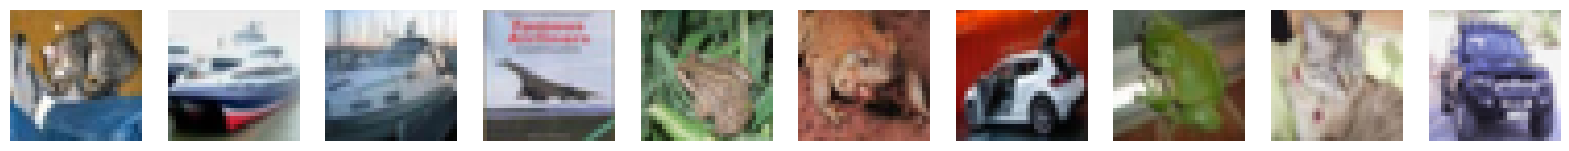

Reconstructions


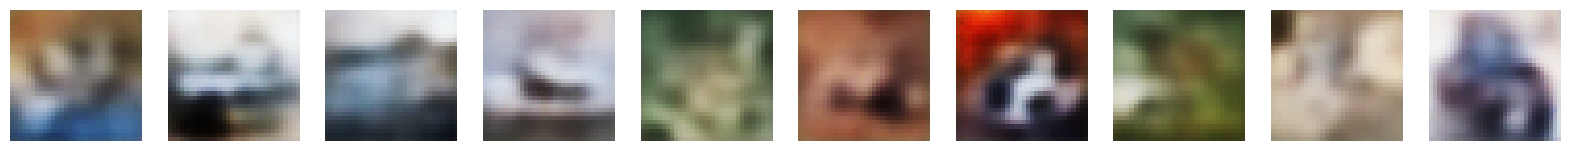

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


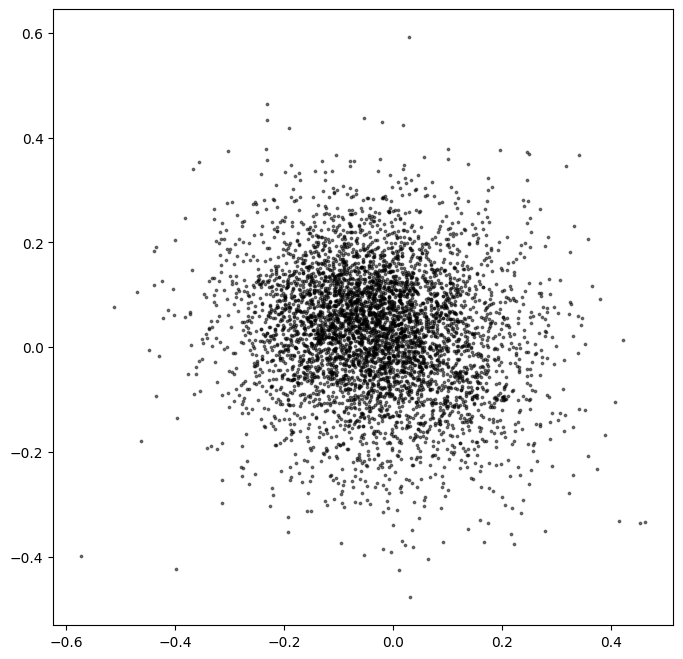

(5000, 128)


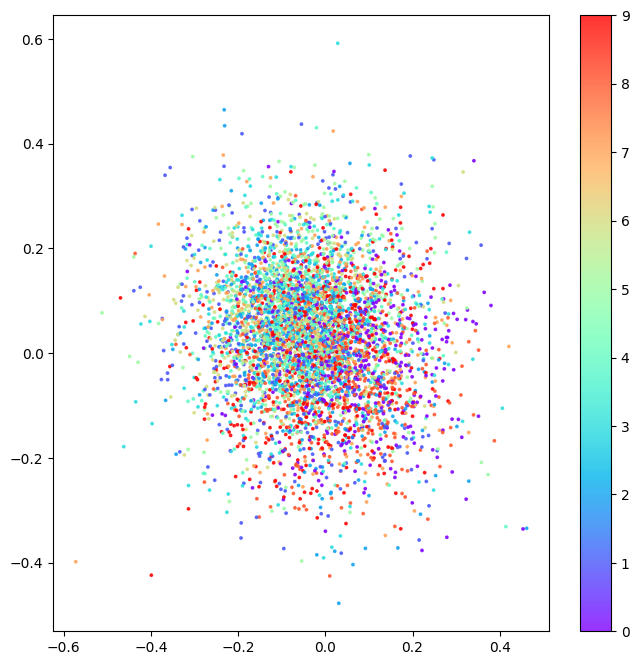

In [50]:
autoencoderEqualLayersDecreasingKernel = Autoencoder(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
    embedding_dim=EMBEDDING_DIM,
    layer_configs=[
    LayerConfig(layer_type='Conv2D', filters=64, kernel_size=(32, 32), strides=2, activation='relu', padding='same'),
    LayerConfig(layer_type='Conv2D', filters=64, kernel_size=(16, 16), strides=2, activation='relu', padding='same'),
    LayerConfig(layer_type='Conv2D', filters=64, kernel_size=(8, 8), strides=2, activation='relu', padding='same'),
    LayerConfig(layer_type='Conv2D', filters=64, kernel_size=(4, 4), strides=2, activation='relu', padding='same'),
    LayerConfig(layer_type='Conv2D', filters=64, kernel_size=(2, 2), strides=2, activation='relu', padding='same'),
])
autoencoderManyLayers.compile(optimizer='adam', loss='binary_crossentropy')
autoencoderManyLayers.train(x_train, x_train, validation_data=(x_test, x_test))
predict_and_visualize(autoencoderManyLayers)

In [57]:
# Just use random layers

import random

# Random power of 2 generator
def random_power_of_2(max_power):
    """Returns a random power of 2 up to 2^max_power."""
    return 2 ** random.randint(2, max_power)

# Random Conv2D layer config generator
def generate_random_layer_config():
    filters = random_power_of_2(9)  # Powers of 2 up to 512 (2^9)
    kernel_size = random_power_of_2(3)  # Powers of 2 up to 8 (2^3)
    strides = random_power_of_2(2)  # Powers of 2 between 2 and 4 (2^1 to 2^2)
    
    return LayerConfig(
        layer_type='Conv2D',
        filters=filters,
        kernel_size=(kernel_size, kernel_size),
        strides=strides,
        activation='relu',
        padding='same'
    )

# Create a list of random layers using LayerConfig
random_layer_configs = [
    generate_random_layer_config(),
    generate_random_layer_config(),
    generate_random_layer_config(),
]

# Define yer autoencoder with these randomized layers
autoencoderRandom = Autoencoder(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
    embedding_dim=EMBEDDING_DIM,
    layer_configs=random_layer_configs
)

# Compile and train the vessel
autoencoderRandom.compile(optimizer='adam', loss='binary_crossentropy')
autoencoderRandom.train(x_train, x_train, validation_data=(x_test, x_test))
predict_and_visualize(autoencoderRandom)

Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 8, 8, 16)       │         3,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 2, 2, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 1, 1, 4)        │         8,196 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_56 (Functional)      │ (None, 64, 64, 3)      │       165,195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,319 (1.18 MB)

 Trainable params: 308,319 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(100, 32, 32, 3), output.shape=(100, 64, 64, 3)